In [5]:
from cirq_sic import *
from cirq.contrib.svg import SVGCircuit

import numpy as np
np.set_printoptions(precision=3, suppress=True)

import matplotlib.pyplot as plt

In [6]:
processor_id = "willow_pink"
globals().update(get_device_data(processor_id))

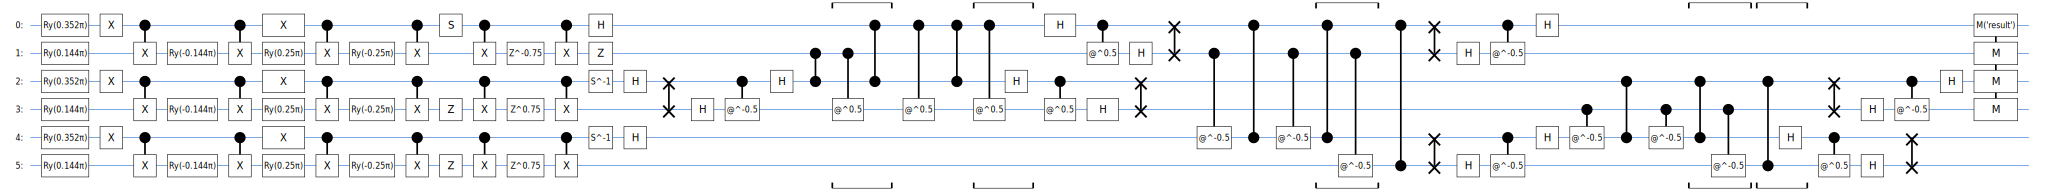

In [7]:
n = 2
q = cirq.LineQubit.range(3*n)
t1, t2, c = q[:n], q[n:2*n], q[2*n:3*n]

# 1) Prepare conjugate fiducial in t1 and fiducial in t2. These are ancillas.
# 2) Transform them into the appropriate ancilla initial state.
# 3) Prepare the system in c: use the fiducial itself!
# 4) Apply the Arthurs-Kelly interaction.
# 5) Measure the ancillas.
circuit = cirq.Circuit((d4_sic_fiducial(c, conjugate=False),
                        qudit_arthurs_kelly(c, t1, t2, d4_sic_fiducial, measure=True)))
SVGCircuit(circuit)

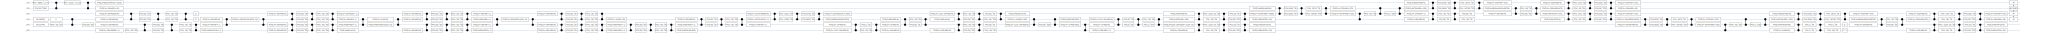

In [8]:
optimized_circuit = process_circuit(circuit, connectivity_graph, gateset)
device.validate_circuit(optimized_circuit)
SVGCircuit(optimized_circuit)

In [9]:
# Exact simulation
N = 50000
s = cirq.Simulator()
samples = s.run(optimized_circuit, repetitions=N)
counts = samples.histogram(key="result")
exact_freqs = np.array([v for k, v in sorted(counts.items())])/N
exact_freqs

array([0.251, 0.049, 0.049, 0.05 , 0.05 , 0.05 , 0.049, 0.05 , 0.051,
       0.05 , 0.049, 0.05 , 0.051, 0.051, 0.052, 0.05 ])

In [34]:
# Direct calculation
d = 4
phi = d4_sic_fiducial_ket()
E = wh_povm(phi)
p = np.array([phi.conj() @ e @ phi for e in E]).real; p

array([0.25, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05])

In [35]:
# Noisy simulation
N = 10000
samples = sampler.run(optimized_circuit, repetitions=N)
counts = samples.histogram(key="result")
noisy_freqs = np.array([v for k, v in sorted(counts.items())])/N
noisy_freqs

array([0.166, 0.06 , 0.076, 0.073, 0.055, 0.061, 0.041, 0.035, 0.069,
       0.052, 0.048, 0.04 , 0.08 , 0.049, 0.041, 0.055])

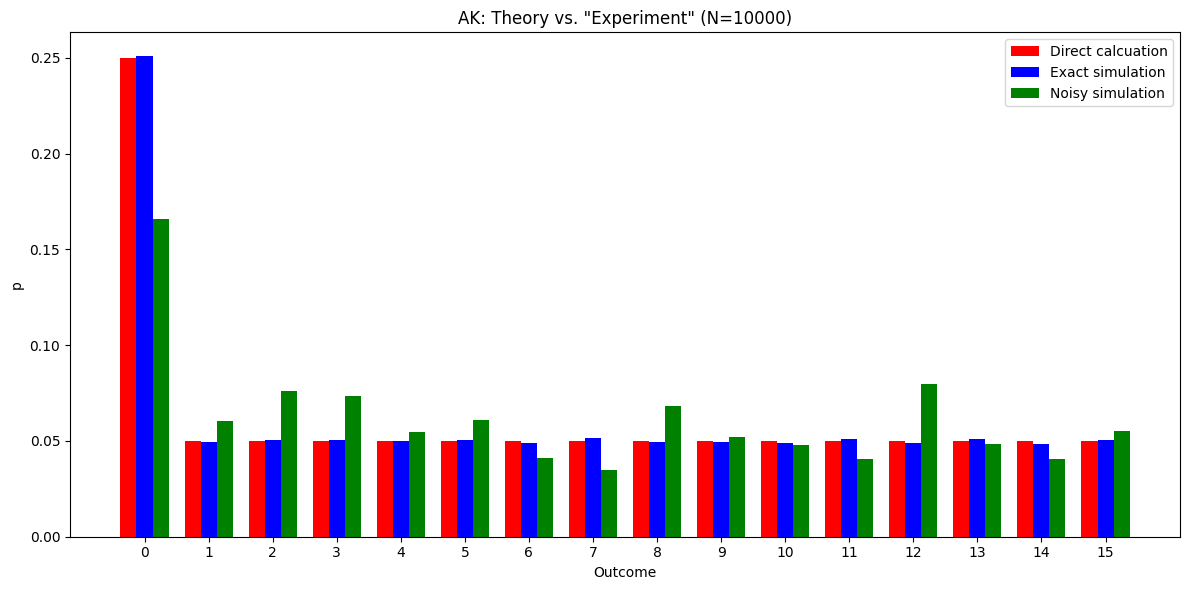

In [36]:
x_pos = np.arange(2**4) 
bar_width = 0.25
plt.figure(figsize=(12, 6))
plt.bar(x_pos - bar_width, p, width=bar_width, label='Direct calcuation', color='red')
plt.bar(x_pos, exact_freqs, width=bar_width, label='Exact simulation', color='blue')
plt.bar(x_pos + bar_width, noisy_freqs, width=bar_width, label='Noisy simulation', color='green')
plt.ylabel('p')
plt.xlabel('Outcome')
plt.title('AK: Theory vs. "Experiment" (N=%d)' % N)
plt.xticks(x_pos)
plt.legend()
plt.tight_layout()

## Gate counts

### Base circuit

In [37]:
fiducial_circuit = cirq.Circuit((d4_sic_fiducial(t1)))
get_gate_counts(fiducial_circuit)

--- Gate Counts (by type) ---
Ry: 5
_PauliX: 2
CXPowGate: 6
ZPowGate: 3
HPowGate: 1


In [38]:
ancilla_prep_circuit = cirq.Circuit((AP(t1,t2)))
get_gate_counts(ancilla_prep_circuit)

--- Gate Counts (by type) ---
SwapPowGate: 1
HPowGate: 2
CZPowGate: 7


In [39]:
ak_circuit = cirq.Circuit((AK(c, t1, t2)))
get_gate_counts(ak_circuit)

--- Gate Counts (by type) ---
HPowGate: 12
CZPowGate: 18
SwapPowGate: 6
MeasurementGate: 1


In [40]:
get_gate_counts(circuit)

--- Gate Counts (by type) ---
Ry: 15
_PauliX: 6
CXPowGate: 18
ZPowGate: 9
HPowGate: 17
SwapPowGate: 7
CZPowGate: 25
MeasurementGate: 1


In [41]:
len(circuit.moments)

47

### Optimized circuit

In [42]:
get_gate_counts(optimized_circuit)

--- Gate Counts (by type) ---
Ry: 2
PhasedXPowGate: 123
_PauliX: 1
CZPowGate: 101
PhasedXZGate: 100
ZPowGate: 4
MeasurementGate: 1


In [43]:
len(optimized_circuit.moments)

149